In [1]:
# imports
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve

np.random.seed(1)

In [2]:
# data load, separate into predictors and labels for both train and test
train = pd.read_csv('../data/processed/train_proc.csv')
test = pd.read_csv('../data/processed/test_proc.csv')

train_X, train_labels = train.drop('status', axis=1), train['status']
features = train_X.columns.tolist()

test_X, test_labels = test.drop('status', axis=1), test['status']

In [3]:
# for scaling features
scaler = StandardScaler()
# define cross-validation procedure
k = 5
cv = KFold(n_splits=k, shuffle=True)

Logistic Regression

In [4]:
lr = LogisticRegression()

pipe = Pipeline(steps=[('scaler', scaler), ('model', lr)])

scores = cross_val_score(pipe, train_X, train_labels, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=False)
print(f'Average ROC AUC and std. across the folds: { np.round((scores.mean(), scores.std()), 3) }')

Average ROC AUC and std. across the folds: [0.768 0.006]


Neural Net

In [5]:
net = MLPClassifier(hidden_layer_sizes=(20), activation='relu', solver='adam', alpha=0.0001, batch_size=32, max_iter=250)

pipe_ = Pipeline(steps=[('scaler', scaler), ('model', net)])

scores_ = cross_val_score(pipe_, train_X, train_labels, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=False)
print(f'Average ROC AUC and std. across the folds: { np.round((scores_.mean(), scores_.std()), 3) }')

Average ROC AUC and std. across the folds: [0.779 0.007]


Let's fit the best model and test it.

Which one is best?

A neural net is a black box whereas the logistic model is interpretable via its coefficients.

Seeing that the neural net is only marginally better in CV, we will use the more robust and intuitive model.

In [7]:
using_lr = True
save = True

clf = lr if using_lr else net
# using the standard scaler
train_X = scaler.fit_transform(train_X)
# cannot use fit_transform for test_X because it will cause overfitting
test_X = scaler.transform(test_X)
# fit the model to our training data
clf.fit(train_X, train_labels)
if save:
    # save it!
    mod = 'lr' if using_lr else 'net'
    with open(f'../data/model/model_{mod}.pkl', 'wb') as f:
        pickle.dump(clf, f)
# predict probabilities of belonging to class for test data
preds_proba = clf.predict_proba(test_X)[:, 1]
# predict the binary class for test data
preds_bin = clf.predict(test_X)
# compute the ROC AUC curve based on our predictions
fpr, tpr, _ = roc_curve(y_true=test_labels, y_score=preds_proba)
# compute the actual ROC AUC score, too
auc = roc_auc_score(y_true=test_labels, y_score=preds_proba)
print(f'ROC AUC score: {round(auc, 3)}')

ROC AUC score: 0.708


In [8]:
# compute the accuracy score
acc = accuracy_score(y_true=test_labels, y_pred=preds_bin)
print(f'Accuracy: {round(acc, 3)}')

Accuracy: 0.665


In [9]:
# finally, showing the confusion matrix
conf_mtx = pd.DataFrame(confusion_matrix(y_true=test_labels, y_pred=preds_bin))
conf_mtx.index.name = 'True'
conf_mtx.columns.name = 'Predicted'

conf_mtx

Predicted,0,1
True,,
0,1328,977
1,697,1998


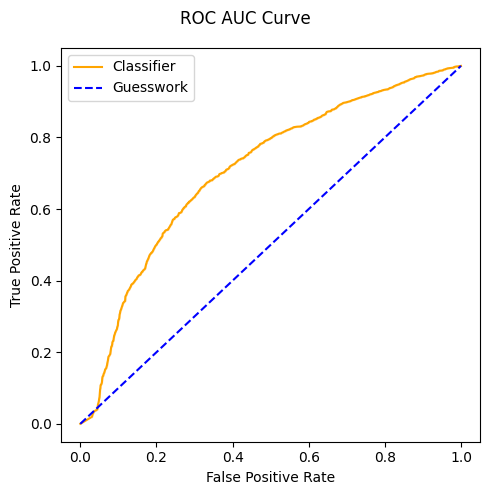

In [10]:
# plotting our ROC AUC curve. should be better than guesswork!
identity = np.linspace(0, 1, 100)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.lineplot(x=fpr, y=tpr, c='orange', label='Classifier', ax=ax)
sns.lineplot(x=identity, y=identity, c='blue', label='Guesswork', linestyle='--', ax=ax)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.suptitle('ROC AUC Curve')
plt.tight_layout()
plt.show()

Interpreting Logistic Regression

$$\begin{align*}
\mathbb{P}(Y=1) = p &= \frac{\exp{(\beta_0 + \sum_{i=1}^{i=n} \beta_i x_i)}}{1+\exp{(\beta_0 + \sum_{i=1}^{i=n} \beta_i x_i)}} \\

\frac{p}{1-p} &= \exp{(\beta_0 + \sum_{i=1}^{i=n} \beta_i x_i)} \\

\log{(\frac{p}{1-p})} &= \beta_0 + \sum_{i=1}^{i=n} \beta_i x_i \\

\end{align*}$$

For every unit increase in $x_j$ the log-odds ratio increases by $\beta_j$.

For every unit increase in $x_j$ the odds ratio increases by $\exp(\beta_j)$.

We must remember that our features have been scaled before feeding them to the model!

In [12]:
def logit2prob(logit):
  # conversion utility function
  odds = np.exp(logit)
  prob = odds / (1 + odds)
  return prob

In [13]:
coef = pd.DataFrame(
        np.concatenate([clf.intercept_.reshape(1, -1), clf.coef_.reshape(1, -1)], axis=1),
        columns=['intercept'] + features
    ).T

coef.columns = ['logit']

coef['prob'] = coef['logit'].apply(lambda x: logit2prob(x))

In [14]:
coef.sort_values(by='logit', ascending=False)

,logit,prob
sd_delinquency_status,0.848982,0.700354
mortgage,0.678855,0.663483
card_balance_card_util_ratio,0.514449,0.625849
delinquency_status_trend,0.374260,0.592488
card_balance,0.250620,0.562329
gender,0.213324,0.553130
intercept,0.208854,0.552024
sd_credit_inquiry,0.127459,0.531822
race_category_White,0.092181,0.523029
credit_inquiry_12m,0.054091,0.513519
